# **SSCS to MIDI**

Developed by André Paiva

Based on SSCS Dataset created by Helena Cuesta and Emilia Gómez

In [248]:
EXECUTE_ON_COLAB = False

In [249]:
import os
import pandas as pd
import h5py
import json
import mido
import zipfile
import tables
import requests
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

if(EXECUTE_ON_COLAB):
    from google.colab import drive
    drive.mount('/content/drive')

In [250]:
import ray

ray.init(ignore_reinit_error=True)

2023-06-09 00:40:04,453	INFO worker.py:1454 -- Calling ray.init() again after it has already been called.


Python version:,3.10.11
Ray version:,2.4.0


## 1 - Auxiliar functions and Variables

### 1.1 - File path variables

In [251]:
if(EXECUTE_ON_COLAB):
    dataset_dir = "/content/Datasets/"
    checkpoint_dir = "/content/drive/MyDrive/SSCS/Checkpoints/sscs.ckpt"
else:
    dataset_dir = "Datasets/"
    checkpoint_dir = "Checkpoints/sscs.ckpt"
zipname = dataset_dir + "SSCS_HDF5.zip"
sscs_dir = dataset_dir + "SSCS_HDF5/"

songs_dir = sscs_dir + "sscs/"
splitname = sscs_dir + "sscs_splits.json"

midi_dir = "./MIDI/midi_file.mid"

### 1.2 - Download/Extract Scripts

In [252]:
def download(url, fname):
    
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get('content-length', 0))
    downloaded_size = 0
    with open(fname, 'wb') as file:
        for data in resp.iter_content(chunk_size=max(4096, int(total/10000))):
            size = file.write(data)
            downloaded_size += size
            percent = min(downloaded_size/total, 1.0)
            print(f"\r{percent:.2%} downloaded", end='')
            
    print()

In [253]:
def sscs_download():
    
    if(not os.path.exists(dataset_dir)):
        os.mkdir(dataset_dir)
   
    if(not os.path.exists(zipname)):
        print("Downloading SSCS Dataset...")
        url = "https://github.com/Xornotor/SSCS_HDF5/releases/download/v1.0/SSCS_HDF5.zip"
        download(url, zipname)
    else:
        print("SSCS Dataset found.")

    if(not os.path.exists(sscs_dir)):
        print("Extracting SSCS Dataset...")
        with zipfile.ZipFile(zipname) as zf:
            os.mkdir(sscs_dir)
            zf.extractall(path=sscs_dir)
    else:
        print("SSCS Dataset already extracted.")
    
    print("Done.")

### 1.3 - Splits, songnames and songlists

In [254]:
def sscs_get_split(split='train'):
    
    if(split.lower() == 'train' or split.lower() == 'validate' or
       split.lower() == 'test'):
        split_list = json.load(open(splitname, 'r'))[split.lower()]
        return split_list
    else:
        raise NameError("Split should be 'train', 'validate' or 'test'.")

In [255]:
def sscs_pick_songlist(first=0, amount=5, split='train'):
    
    songnames = sscs_get_split(split)
    return songnames[first:first+amount]

In [256]:
def sscs_pick_random_song(split='train'):
    
    songnames = sscs_get_split(split)
    rng = np.random.randint(0, len(songnames))
    return songnames[rng]

In [257]:
def sscs_pick_multiple_random_songs(amount, split='train'):
    
    return [sscs_pick_random_song() for i in range(amount)]

### 1.4 - Read voices from songs

In [258]:
@ray.remote
def sscs_read_voice(name, voice):

    if  (voice != 'mix' and \
        voice != 'soprano' and \
        voice != 'alto' and \
        voice != 'tenor' and \
        voice != 'bass'):
        raise NameError("Specify voice with 'soprano', 'alto', \
                        'tenor', 'bass' or 'mix'.")
    
    filename = songs_dir + name + ".h5"
    return pd.read_hdf(filename, voice).T

In [259]:
def sscs_read_all_voices(name):
    
    voices = ['mix', 'soprano', 'alto', 'tenor', 'bass']
    data_access = [sscs_read_voice.remote(name, voice) for voice in voices]
    df_voices = ray.get(data_access)
    mix = df_voices[0]
    satb = df_voices[1:]
    return mix, satb

### 1.5 - Downsample songs

In [260]:
def sscs_downsample(voice):
    voice_0 = np.array(voice.T[0::5]).T
    voice_1 = np.array(voice.T[1::5]).T
    voice_2 = np.array(voice.T[2::5]).T
    voice_3 = np.array(voice.T[3::5]).T
    voice_4 = np.array(voice.T[4::5]).T

    voice_sums = voice_0 + voice_1 + voice_2 + voice_3 + voice_4

    def downsample_threshold(item):
        if item >= 1.0: return 1.0
        else: return 0.0

    vectorized_downsample_threshold = np.vectorize(downsample_threshold)

    voice_sums = vectorized_downsample_threshold(voice_sums)

    return voice_sums

### 1.6 - Plots

In [261]:
def sscs_plot(dataframe):

    aspect_ratio = (3/8)*dataframe.shape[1]/dataframe.shape[0]
    fig, ax = plt.subplots(figsize=(13, 7))
    im = ax.imshow(dataframe, interpolation='nearest', aspect=aspect_ratio,
        cmap = mpl.colormaps['BuPu'])
    ax.invert_yaxis()
    plt.show()

## 2 - Download and extract dataset SSCS

In [262]:
sscs_download()

SSCS Dataset found.
SSCS Dataset already extracted.
Done.


## 3 - Function to convert a song in SSCS to MIDI

The following code was adapted from [midi_to_numpy](https://github.com/qsdfo/midi_to_numpy/blob/master/write_midi.py) by qsdfo.

In [272]:
def write_midi(pr, ticks_per_beat=52, write_path=midi_dir, tempo=90):
    def pr_to_list(pr):
        # List event = (pitch, velocity, time)
        T, N = pr.shape
        t_last = 0
        pr_tm1 = np.zeros(N)
        list_event = []
        for t in range(T):
            pr_t = pr[t]
            mask = (pr_t != pr_tm1)
            if(N == 360): range_step = 5
            else: range_step = 1
            if (mask).any():
                for n in range(0, N, range_step):
                    if mask[n]:
                        if(N == 72):
                            pitch = 21 + n
                        else:
                            pitch = 21 + int(n/5)
                        if(int(pr_t[n] * 127)) >= 20:
                            velocity = 127
                        else:
                            velocity = 0
                        # Time is incremented since last event
                        t_event = t - t_last
                        t_last = t
                        list_event.append((pitch, velocity, t_event))
            pr_tm1 = pr_t
        return list_event
    # Tempo
    microseconds_per_beat = mido.bpm2tempo(tempo)
    # Write a pianoroll in a midi file
    mid = mido.MidiFile()
    mid.ticks_per_beat = ticks_per_beat


    # Add a new track with the instrument name to the midi file
    track = mid.add_track("Voice Aah")
    # transform the matrix in a list of (pitch, velocity, time)
    events = pr_to_list(pr)
    print(events)
    # Tempo
    track.append(mido.MetaMessage('set_tempo', tempo=microseconds_per_beat))
    # Add the program_change
    program = 53 #Choir Aahs = 53, Voice Oohs (or Doos) = 54, Synch Choir = 55
    track.append(mido.Message('program_change', program=program))

    # This list is required to shut down
    # notes that are on, intensity modified, then off only 1 time
    # Example :
    # (60,20,0)
    # (60,40,10)
    # (60,0,15)
    notes_on_list = []
    # Write events in the midi file
    for event in events:
        pitch, velocity, time = event
        if velocity == 0:
            # Get the channel
            track.append(mido.Message('note_off', note=pitch, velocity=0, time=time))
            if(pitch in notes_on_list):
                notes_on_list.remove(pitch)
        else:
            if pitch in notes_on_list:
                track.append(mido.Message('note_off', note=pitch, velocity=0, time=time))
                notes_on_list.remove(pitch)
                time = 0
            track.append(mido.Message('note_on', note=pitch, velocity=velocity, time=time))
            notes_on_list.append(pitch)
    mid.save(write_path)
    return

## 4 - Pick song and convert voices

In [264]:
song = sscs_pick_random_song()
mix, satb = sscs_read_all_voices(song)
sop = satb[0].to_numpy().T
alto = satb[1].to_numpy().T
ten = satb[2].to_numpy().T
bass = satb[3].to_numpy().T
mix = mix.T

down_mix = sscs_downsample(mix)
down_sop = sscs_downsample(sop)
down_alto = sscs_downsample(alto)
down_ten = sscs_downsample(ten)
down_bass = sscs_downsample(bass)

print(down_mix.shape)

(48105, 72)


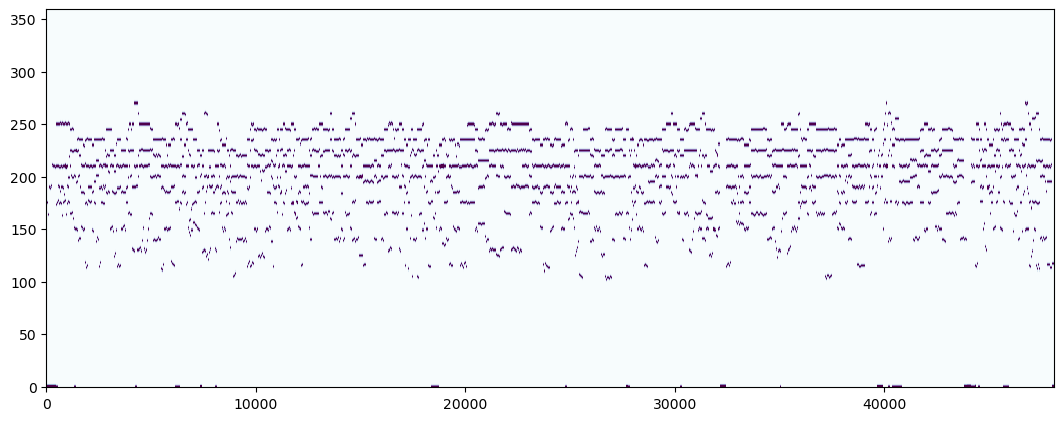

In [265]:
sscs_plot(mix.T)

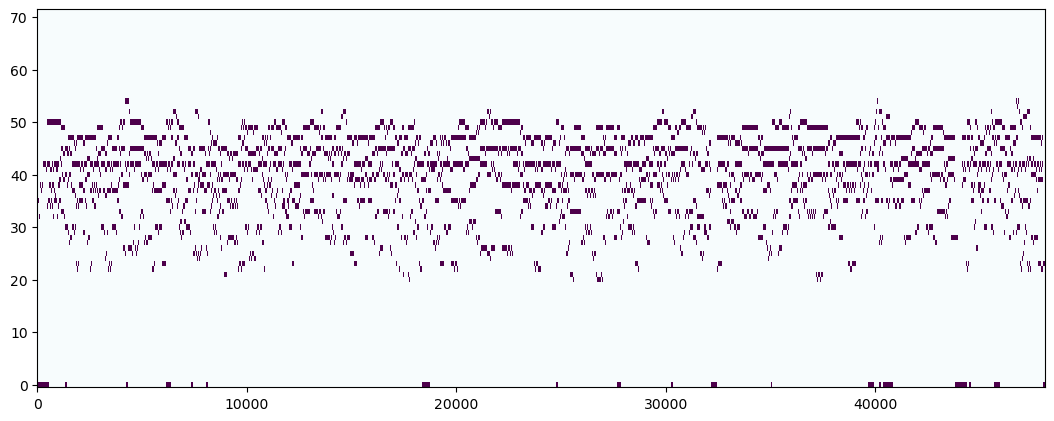

In [266]:
sscs_plot(down_mix.T)

In [273]:
write_midi(down_sop, write_path='./MIDI/soprano.mid')
write_midi(down_alto, write_path='./MIDI/alto.mid')
write_midi(down_ten, write_path='./MIDI/tenor.mid')
write_midi(down_bass, write_path='./MIDI/bass.mid')

[(21, 127, 0), (21, 0, 474), (70, 127, 0), (70, 0, 2), (71, 127, 0), (70, 127, 6), (71, 0, 0), (70, 0, 2), (71, 127, 0), (70, 127, 1), (71, 0, 0), (70, 0, 2), (71, 127, 0), (70, 127, 51), (71, 0, 0), (70, 0, 4), (71, 127, 0), (70, 127, 74), (71, 0, 0), (70, 0, 4), (71, 127, 0), (70, 127, 101), (71, 0, 0), (70, 0, 2), (71, 127, 0), (70, 127, 1), (71, 0, 0), (70, 0, 3), (71, 127, 0), (70, 127, 15), (71, 0, 0), (70, 0, 1), (71, 127, 0), (70, 127, 13), (71, 0, 0), (70, 0, 1), (71, 127, 0), (70, 127, 40), (71, 0, 0), (70, 0, 1), (71, 127, 0), (70, 127, 43), (71, 0, 0), (70, 0, 6), (71, 127, 0), (70, 127, 18), (71, 0, 0), (70, 0, 3), (71, 127, 0), (70, 127, 2), (71, 0, 0), (70, 0, 1), (71, 127, 0), (70, 127, 51), (71, 0, 0), (70, 0, 5), (71, 127, 0), (70, 127, 21), (71, 0, 0), (70, 0, 3), (71, 127, 0), (70, 127, 50), (71, 0, 0), (70, 0, 1), (71, 127, 0), (70, 127, 53), (71, 0, 0), (70, 0, 3), (71, 127, 0), (70, 127, 9), (71, 0, 0), (70, 0, 2), (71, 127, 0), (70, 127, 26), (71, 0, 0), (70, 0,

In [274]:
write_midi(sop, write_path='./MIDI/soprano_high.mid')
write_midi(alto, write_path='./MIDI/alto_high.mid')
write_midi(ten, write_path='./MIDI/tenor_high.mid')
write_midi(bass, write_path='./MIDI/bass_high.mid')

[(21, 127, 0), (21, 0, 474), (70, 0, 0), (71, 127, 0), (70, 0, 2), (71, 127, 0), (70, 0, 6), (71, 127, 0), (70, 0, 2), (71, 127, 0), (70, 0, 1), (71, 127, 0), (70, 0, 2), (71, 127, 0), (71, 127, 33), (72, 0, 0), (71, 127, 3), (72, 0, 0), (70, 0, 15), (71, 127, 0), (70, 0, 4), (71, 127, 0), (71, 127, 39), (72, 0, 0), (71, 127, 2), (72, 0, 0), (71, 127, 18), (72, 0, 0), (71, 127, 1), (72, 0, 0), (70, 0, 14), (71, 127, 0), (70, 0, 4), (71, 127, 0), (71, 127, 71), (72, 0, 0), (71, 127, 2), (72, 0, 0), (70, 0, 28), (71, 127, 0), (70, 0, 2), (71, 127, 0), (70, 0, 1), (71, 127, 0), (70, 0, 3), (71, 127, 0), (70, 0, 15), (71, 127, 0), (70, 0, 1), (71, 127, 0), (70, 0, 13), (71, 127, 0), (70, 0, 1), (71, 127, 0), (71, 127, 30), (72, 0, 0), (71, 127, 1), (72, 0, 0), (71, 127, 1), (72, 0, 0), (71, 127, 1), (72, 0, 0), (70, 0, 7), (71, 127, 0), (70, 0, 1), (71, 127, 0), (71, 127, 29), (72, 0, 0), (71, 127, 4), (72, 0, 0), (70, 0, 10), (71, 127, 0), (70, 0, 6), (71, 127, 0), (70, 0, 18), (71, 127, 